In [2]:
import logging

import numpy as np
import os
import pathlib
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

from utils.load_dataset import load_dataset

tf.get_logger().setLevel(logging.ERROR)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

Загрузим данные, разбив на тренировочную, валидационную и тестовую выборки:

In [4]:
train_ds, val_ds, test_ds = load_dataset(os.path.abspath('images'))

Found 19794 files belonging to 40 classes.
Using 13856 files for training.
Found 19794 files belonging to 40 classes.
Using 5938 files for validation.


Определим функцию для создания модели, которая будет включать несколько гиперпараметров:

In [5]:
class_names = train_ds.class_names
num_classes = len(class_names)
from utils.load_dataset import load_dataset

def build_model(hp):
    n_conv = hp.Int("n_conv", min_value=3, max_value=8, default=3, step=1)
    n_dense = hp.Int("n_dense", min_value=1, max_value=3, default=1, step=1)
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(256, 256, 3)))
    model.add(tf.keras.layers.Rescaling(1./255))
    for _ in range(n_conv):
        model.add(tf.keras.layers.Conv2D(32, 3, activation='relu'))
        model.add(tf.keras.layers.MaxPooling2D())
    model.add(tf.keras.layers.Flatten())
    for i in range(n_dense):
        model.add(tf.keras.layers.Dense(hp.Int(f"n_neurons_{i}", min_value=160, max_value=320, step=32), activation='relu'))
        if hp.Boolean(f"dropout_{i}"):
            model.add(tf.keras.layers.Dropout(hp.Choice(f"dropuot_{i}_size", [0.1, 0.2, 0.3, 0.4])))
    model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-3, sampling="log")
    model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
      loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
      metrics=['accuracy']  
    )
    return model

Проведем поиск оптимальных гиперпараметров при помощи RandomSearch модуля keras_tuner:

In [ ]:
import keras_tuner as kt

es = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=2,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0
)

random_search_tuner = kt.RandomSearch(
    build_model, objective="val_accuracy", max_trials=15, overwrite=True,
    directory="random_search", project_name="simple_model_tuning", seed=2)
random_search_tuner.search(train_ds, epochs=10, validation_data=val_ds, callbacks=[es])

Лучшие найденные параметры:

In [7]:
top_params = random_search_tuner.get_best_hyperparameters()
print(top_params[0].values)

{'n_conv': 4, 'n_dense': 1, 'n_neurons_0': 224, 'dropout_0': True, 'learning_rate': 0.0008030805486457598, 'dropuot_0_size': 0.1}


In [8]:
best_model = build_model(top_params[0])
best_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 60, 60, 32)       

Натренируем модель с нуля, используя найденные нами лучшие гиперпараметры:

In [10]:
%%time
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=2,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0
)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "my_checkpoints/simple_model_tuned.weights.h5",
    save_weights_only=True)

history = best_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=15,
  callbacks=[checkpoint_cb, es]
)

Epoch 1/15
433/433 [==============================] - 24s 55ms/step - loss: 2.1997 - accuracy: 0.4006 - val_loss: 2.0511 - val_accuracy: 0.4510
Epoch 2/15
433/433 [==============================] - 24s 56ms/step - loss: 1.5893 - accuracy: 0.5546 - val_loss: 1.9472 - val_accuracy: 0.4963
Epoch 3/15
433/433 [==============================] - 25s 56ms/step - loss: 1.0880 - accuracy: 0.6844 - val_loss: 2.1531 - val_accuracy: 0.5037
Epoch 4/15
433/433 [==============================] - 25s 57ms/step - loss: 0.7029 - accuracy: 0.7878 - val_loss: 2.3560 - val_accuracy: 0.5213
Epoch 5/15
433/433 [==============================] - 24s 55ms/step - loss: 0.4453 - accuracy: 0.8654 - val_loss: 2.8420 - val_accuracy: 0.5057
Epoch 6/15
433/433 [==============================] - 26s 59ms/step - loss: 0.3196 - accuracy: 0.8979 - val_loss: 3.0372 - val_accuracy: 0.5135
CPU times: user 9min 23s, sys: 32 s, total: 9min 55s
Wall time: 2min 28s


Протестируем модель на нашей тестовой выборке:

In [11]:
best_model.evaluate(test_ds)

93/93 [==============================] - 3s 27ms/step - loss: 2.4845 - accuracy: 0.5064


[2.484485626220703, 0.5063844323158264]

In [12]:
predictions = best_model.predict(test_ds)

93/93 [==============================] - 3s 26ms/step


Построим матрицу ошибок:

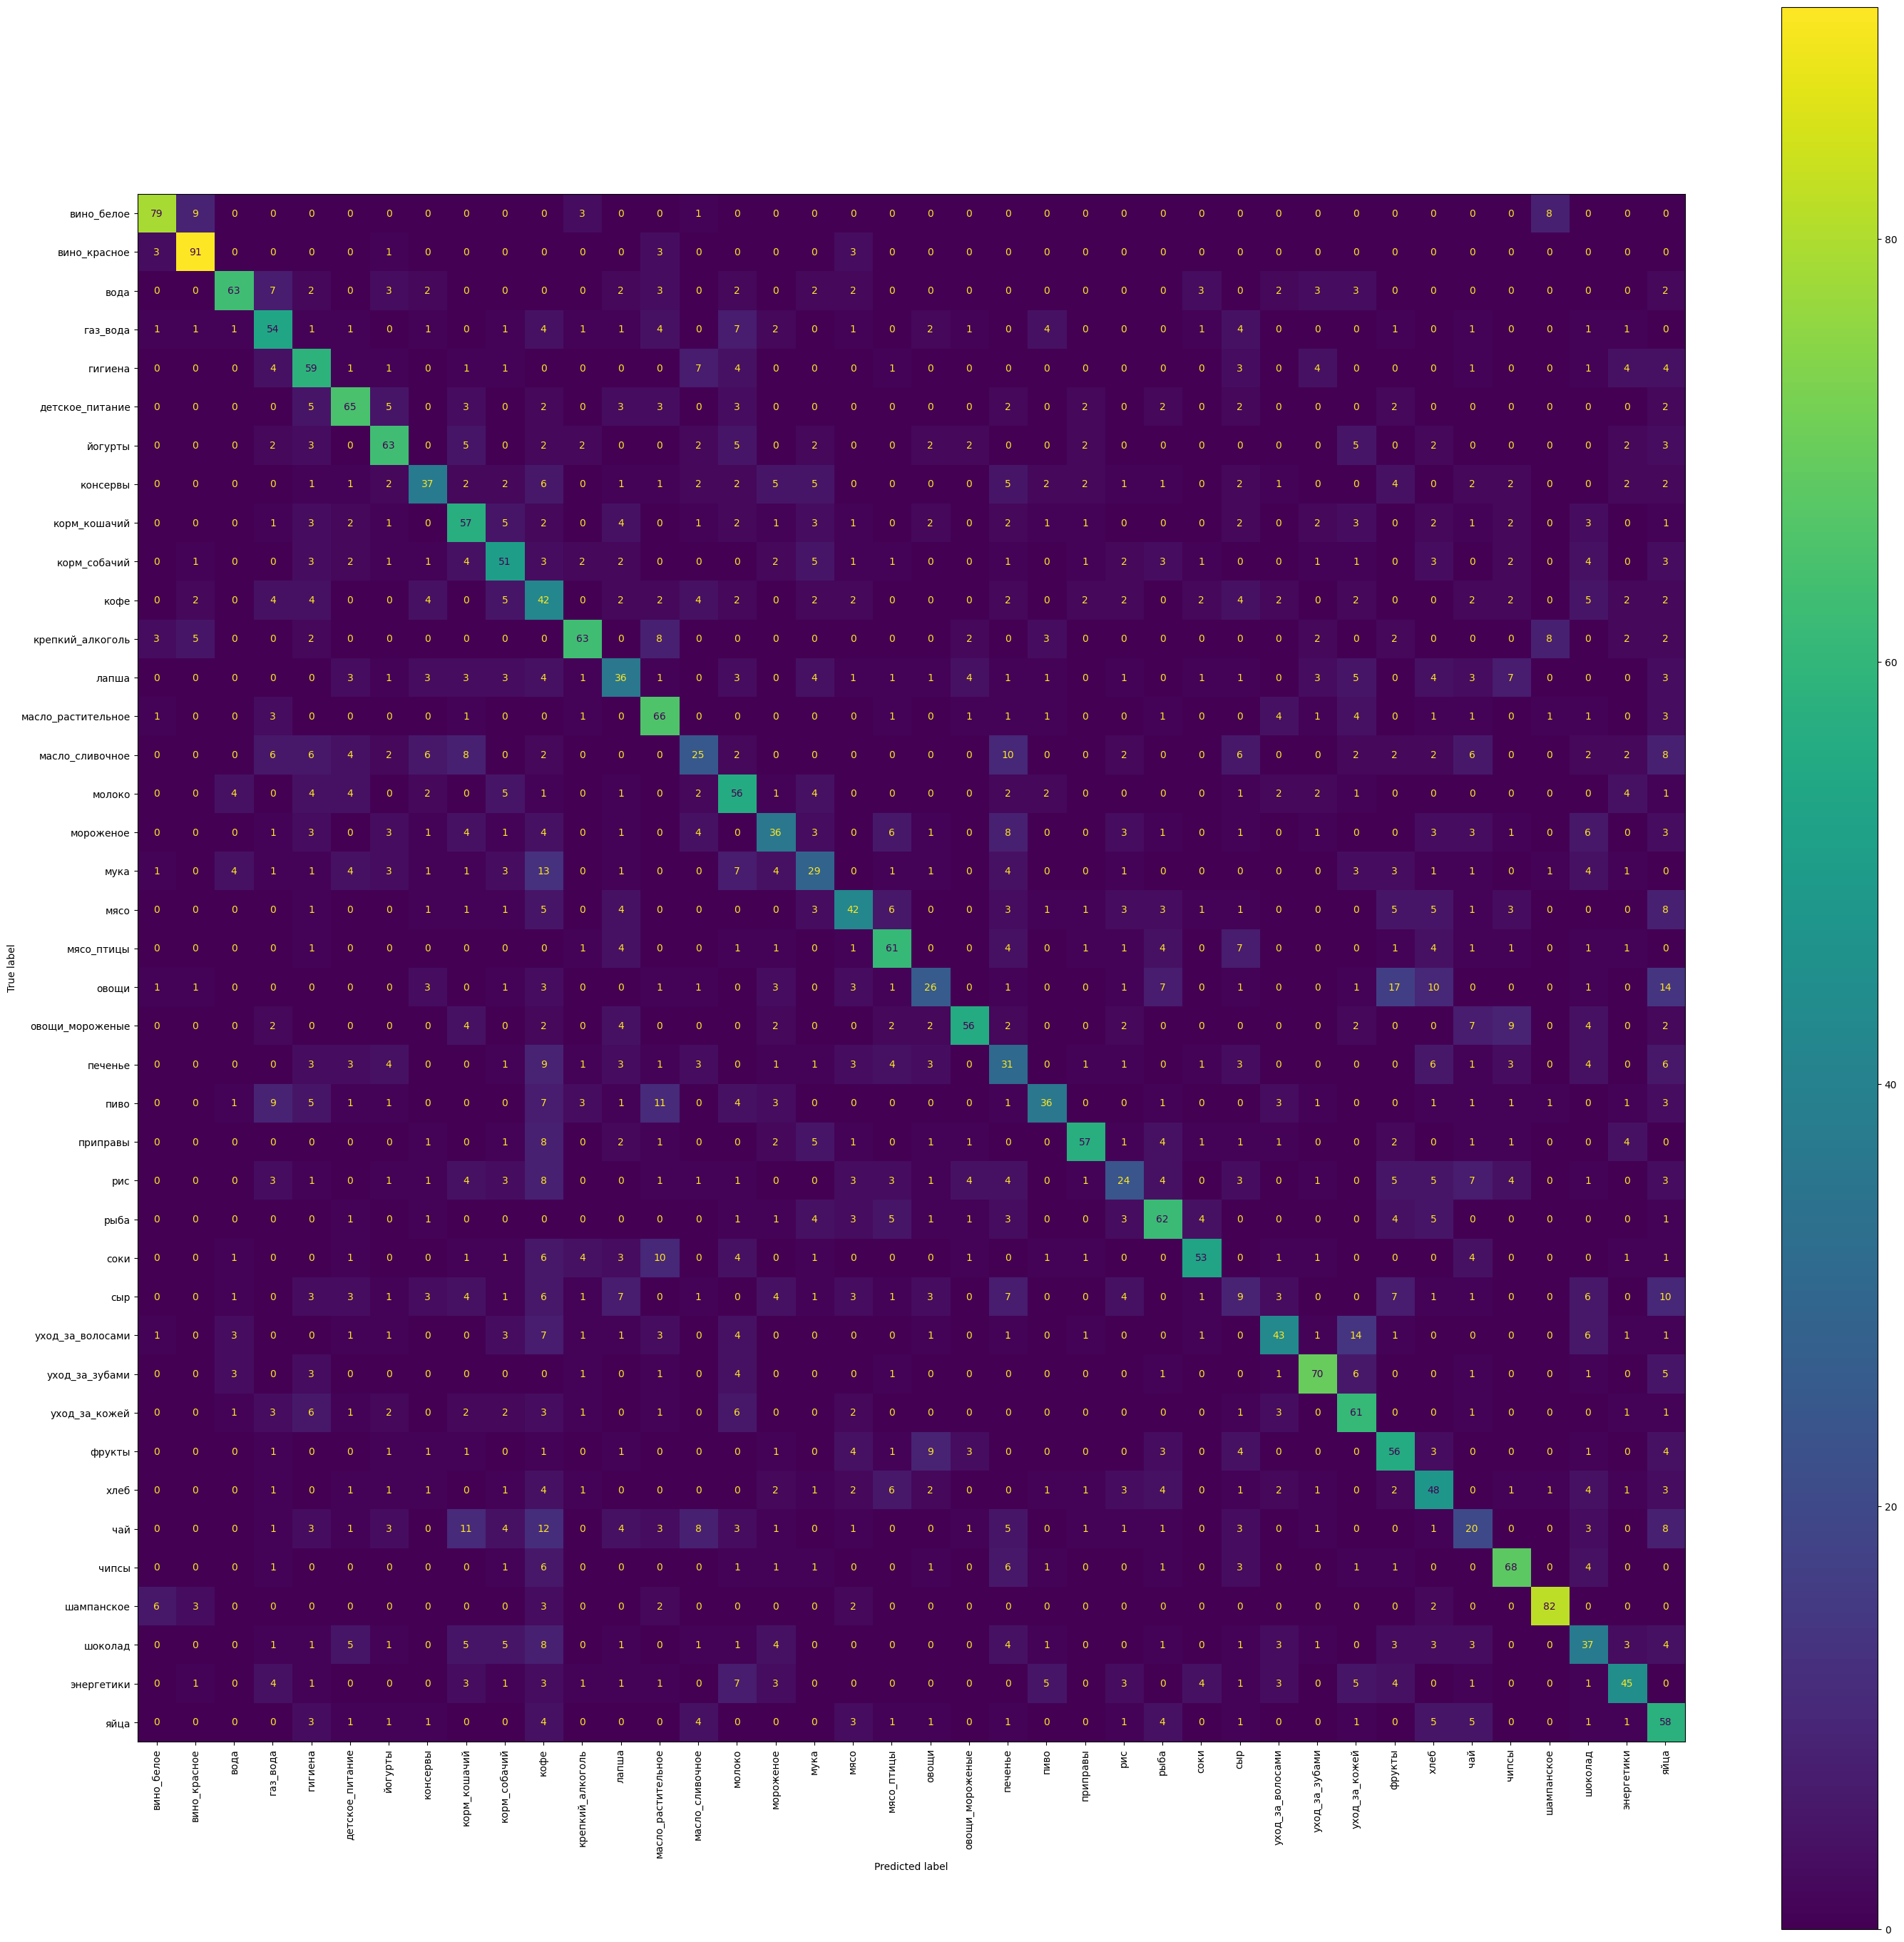

In [15]:
from utils.confusion_matrix import plot_confusion_matrix

plot_confusion_matrix(best_model, test_ds, train_ds.class_names)

Сохраним натренированную модель:

In [17]:
best_model.save('ready_models/simple_model_tuned.keras')